<a href="https://colab.research.google.com/github/Lucky-Millare/CSST106-CS4B/blob/main/YOLO-Object-Detection/4B-MILLARE-MP5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Problem: Object Detection and Recognition using YOLO.**

## Import Libraries

In [ ]:
# Download YOLOv3 weights, config, and class names
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true -O yolov3.cfg
!wget https://github.com/pjreddie/darknet/blob/master/data/coco.names?raw=true -O coco.names

--2024-11-02 15:58:03--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  34.3MB/s    in 7.7s    

2024-11-02 15:58:11 (30.9 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2024-11-02 15:58:11--  https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/pjreddie/darknet/raw/refs/heads/master/cfg/yolov3.cfg [following]
--2024-11-02 15:58:11--  https://github.com/pjreddie/darknet/raw/refs/heads/master/cfg/yolov3.cfg
Reusing existing connection to github.com:443.
HTT

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from PIL import Image
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load the Model

In [ ]:
net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')
with open('coco.names', 'r') as f:
    classes = [line.strip() for line in f.readlines()]

Load the Image

In [ ]:
image_paths = ['/content/drive/MyDrive/image2.0.jpg' , '/content/drive/MyDrive/thing.jpg' , '/content/drive/MyDrive/thing1.jpg']
processed_images = []

Object Detection

In [ ]:
for image_path in image_paths:
    # Read the image from the given path
    image = cv2.imread(image_path)

    # Get the dimensions of the image
    height, width, _ = image.shape

    # Prepare the image for the neural network by creating a blob (pre-processed image)
    # - scale factor of 0.00392 (1/255) to normalize pixel values to [0, 1]
    # - resize to 416x416 (standard YOLO input size)
    # - swapRB=True changes BGR to RGB
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

    # Set the blob as input to the neural network
    net.setInput(blob)

    # Get output layer names for the YOLO model to specify where we want the forward pass to end
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

    # Run the forward pass and get the network outputs
    outs = net.forward(output_layers)

    # Initialize lists to store detected bounding boxes, confidences, and class IDs
    boxes, confidences, class_ids = [], [], []

    # Process each output from the model
    for out in outs:
        for detection in out:
            # Detection includes confidence scores for each class starting from index 5
            scores = detection[5:]

            # Get the class ID with the highest score and the associated confidence
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            # Only consider detections with confidence greater than 0.5
            if confidence > 0.5:
                # Calculate the center and dimensions of the bounding box relative to the image size
                center_x, center_y = int(detection[0] * width), int(detection[1] * height)
                w, h = int(detection[2] * width), int(detection[3] * height)

                # Calculate the top-left corner coordinates of the bounding box
                x, y = int(center_x - w / 2), int(center_y - h / 2)

                # Add box coordinates, confidence score, and class ID to their respective lists
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Apply Non-Maximum Suppression to filter overlapping bounding boxes
    # - i.e., keeps only the highest confidence box for each detected object
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    # Draw bounding boxes and labels for the final detections on the image
    for i in indexes.flatten():
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])

        # Draw the bounding box
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Put the label text above the bounding box
        cv2.putText(image, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Convert the image from BGR (OpenCV default) to RGB for displaying with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Append the processed image to the list of results
    processed_images.append(image_rgb)


### Display the Images

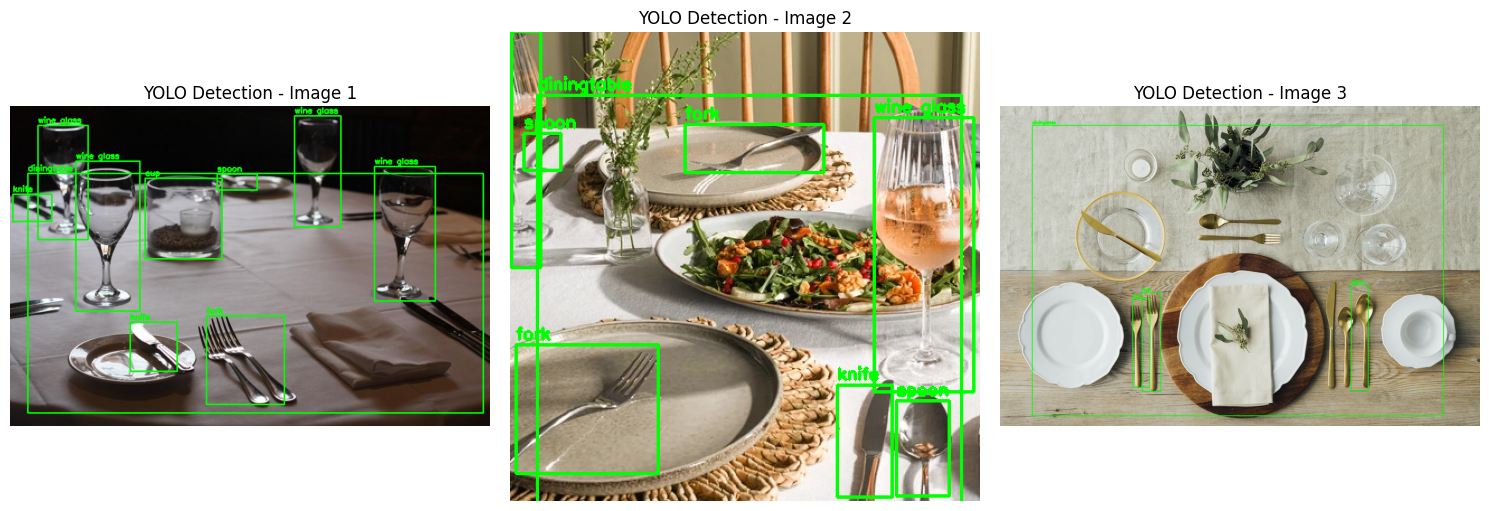

In [ ]:
plt.figure(figsize=(15, 5))
for i, img in enumerate(processed_images):
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(f"YOLO Detection - Image {i + 1}")
    plt.axis('off')
plt.tight_layout()

plt.show()